# script COTO

In [1]:
import pandas as pd
import random
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

def get_coto(url: str) -> float:
    """Retrieve and parse product information from Coto's webpage.
    
    Args:
        url (str): URL of the product page.
    
    Returns:
        float: Product price or None if failed.
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers)        
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            product_name = soup.find('h1', class_='product_page').get_text(strip=True)
            product_price = soup.find('span', class_='atg_store_newPrice').get_text(strip=True).replace('$', '').replace('.', '').replace(',', '.')
            
            print(f'Product Name: {product_name}')
            print(f'Price: {product_price}')
            return float(product_price)
        else:
            print(f'Failed to retrieve webpage, status code: {response.status_code}')
            return None
    except requests.RequestException as e:
        print(f'Request failed: {e}')
        return None
    
    
def get_jumbo(url: str) -> float:
    """Retrieve and parse product information from Jumbo's webpage.
    
    Args:
        url (str): URL of the product page.
    
    Returns:
        float: Product price or None if failed.
    """
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        script = soup.find('script', {'type': 'application/ld+json'})
        
        if script:
            data = json.loads(script.string)
            product_name = data.get('name')
            product_price = data.get('offers', {}).get('lowPrice')

            print(f'Product Name: {product_name}')
            print(f'Price: {product_price}')
            return float(product_price)
        else:
            print('Product data in JSON format not found.')
            return None
    else:
        print(f'Failed to retrieve webpage, status code: {response.status_code}')
        return None
        
        
def create_df(articulos: dict, product_key: str) -> pd.DataFrame:
    """Create a DataFrame with product prices across different stores.
    
    Args:
        articulos (dict): Mapping of stores to product URLs.
        product_key (str): Key to identify the product across different stores.
    
    Returns:
        pd.DataFrame: DataFrame containing product prices.
    """
    data_dict = {}
    
    store_function_mapping = {
        'coto': get_coto,
        'jumbo': get_jumbo,
        'carrefour': get_jumbo  # Assuming similar to Jumbo for demo purposes
    }
    
    for store, products in articulos.items():
        if product_key in products:
            if store in store_function_mapping:
                get_function = store_function_mapping[store]
                product_price = get_function(products[product_key])
                if product_price is not None:
                    data_dict[store] = product_price
                
    df = pd.DataFrame([data_dict])   
    current_date = datetime.now().strftime('%d-%m-%Y')
    df.index = [current_date]    
    
    return df

def mock_data_random_decrease(df: pd.DataFrame, days_back: int, percentage_decrease_min: float, percentage_decrease_max: float) -> pd.DataFrame:
    """Generate mock data simulating a random decrease in price over specified days.
    
    Args:
        df (pd.DataFrame): DataFrame with the most recent prices.
        days_back (int): Number of days to generate data for.
        percentage_decrease_min (float): Minimum percentage decrease.
        percentage_decrease_max (float): Maximum percentage decrease.
    
    Returns:
        pd.DataFrame: Updated DataFrame with simulated past prices.
    """
    new_df = df.copy()
    new_df.index = pd.to_datetime(new_df.index, format='%d-%m-%Y')
    last_known_prices = new_df.iloc[-1]

    for day in range(1, days_back + 1):
        random_decrease = random.uniform(percentage_decrease_min, percentage_decrease_max) / 100
        past_date = new_df.index[-1] - timedelta(days=1)
        decreased_prices = last_known_prices * (1 - random_decrease)
        new_df.loc[past_date] = decreased_prices
        last_known_prices = decreased_prices
    new_df.sort_index(ascending=True, inplace=True)
   
    return new_df


import requests

def get_meli(item_id, access_token=None):
    url = f'https://api.mercadolibre.com/items/{item_id}/sale_price'
    headers = {
     #   'Authorization': f'Bearer {access_token}'
    }
    
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        return data.get('amount')
    else:
        raise Exception(f"Error fetching item price: {response.status_code} {response.text}")
        
        
def plot_timeline(df, item_name):

    sns.set_theme()
    ax = df.plot(kind='line', figsize=(10, 6))

    ax.set_xlabel('Fechas')
    ax.set_ylabel('Precio')

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    ax.set_title(item_name)
    plt.show()


In [2]:
df_raw = pd.read_excel('Canasta Picada.xlsx')
df_raw.drop('Mercado Libre', axis=1, inplace=True)

In [3]:
articulos = {}
for _, row in df_raw.iterrows():
    for col in df_raw.columns[1:]:
        if pd.notna(row[col]):
            if col.lower() not in articulos:
                articulos[col.lower()] = {}
            articulos[col.lower()][row['Unnamed: 0'].replace(' ', '_')] = row[col]

In [4]:
articulos['carrefour']['aceitunas'] = 'https://www.carrefour.com.ar/aceitunas-verdes-nucete-premium-360-g/p'
articulos['jumbo']['aceitunas'] = 'https://www.jumbo.com.ar/aceitunas-nucete-verde-descarozadas-80-gr/p'

In [5]:
df_list = []
for j in articulos['coto'].keys():
    df = create_df(articulos, j)
    df_list.append((j,df))

Product Name: Salamin Tand.Fin Cagnoli Xkg
Price: 15900.00
Product Name: Salamin Cagnoli Picado Fino 1 Kg
Price: 19402
Product Name: Salamín tandilero Cagnoli picado fino x kg.
Price: 17790
Product Name: Cerveza Lager Imperial  Lata 710 CC
Price: 2530.00
Product Name: Cerveza Imperial Rubia 710 Ml
Price: 2530
Product Name: Cerveza rubia Imperial lager 710 cc.
Price: 2530
Product Name: Papas Fritas Clasicas Lays 40g
Price: 1315.99
Product Name: Papas fritas Lays Clásicas x 40 Gr
Price: 1600
Product Name: Papas fritas Krachitos pay 150 g.
Price: 2244
Product Name: Queso Azul. . SANTA ROSA Xkg
Price: 16959.00
Product Name: Queso Azul Santa Rosa Horma 1 Kg
Price: 19949
Product Name: Queso azul Santa Rosa x kg.
Price: 16785
Product Name: Aceitunas Verdes NUCETE   Descarozada    Sachet 180 Gr
Price: 790.00
Product Name: Aceitunas Nucete Verde Descarozadas 80 Gr
Price: 800
Product Name: Aceitunas verdes Nucete premium 360 g.
Price: 3419
Product Name: Maní Frito Salado Croppers 105g
Price: 113

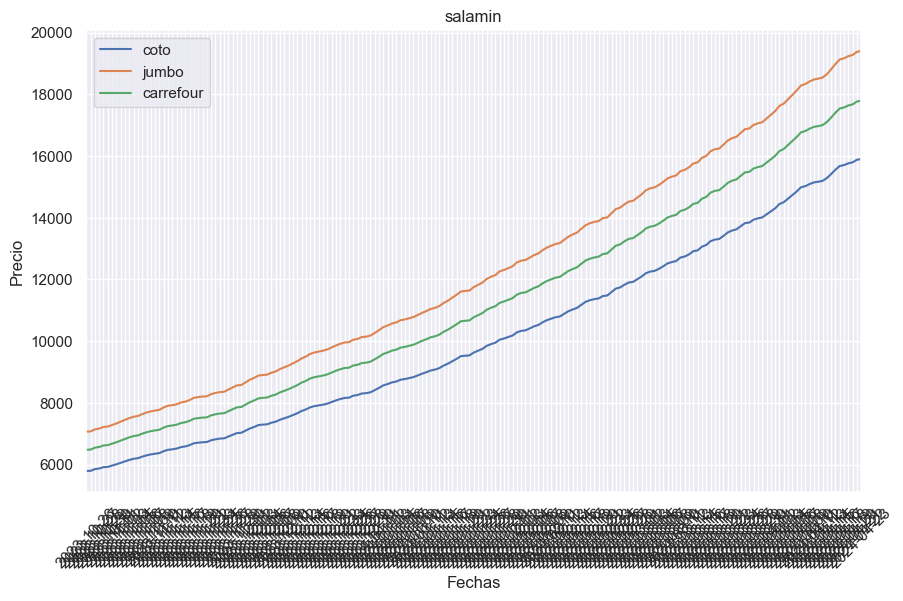

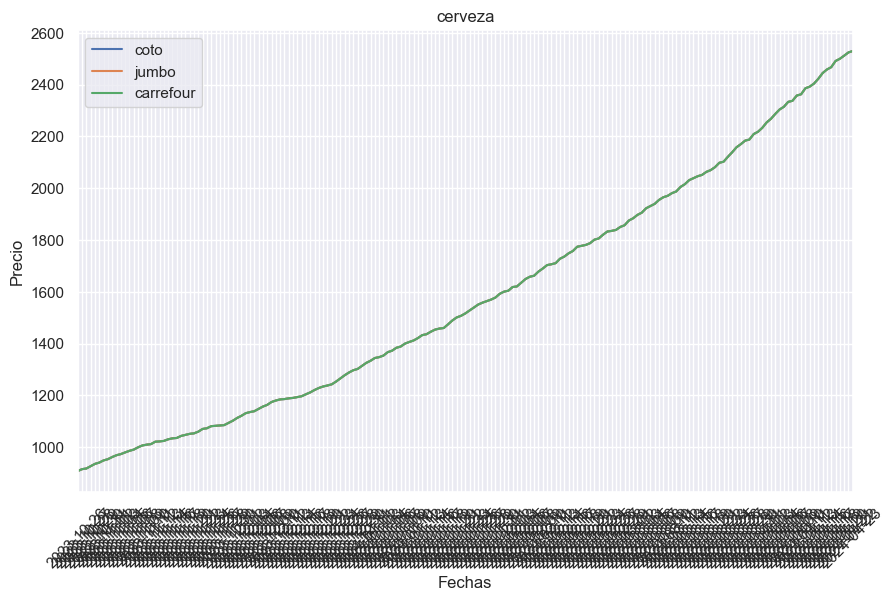

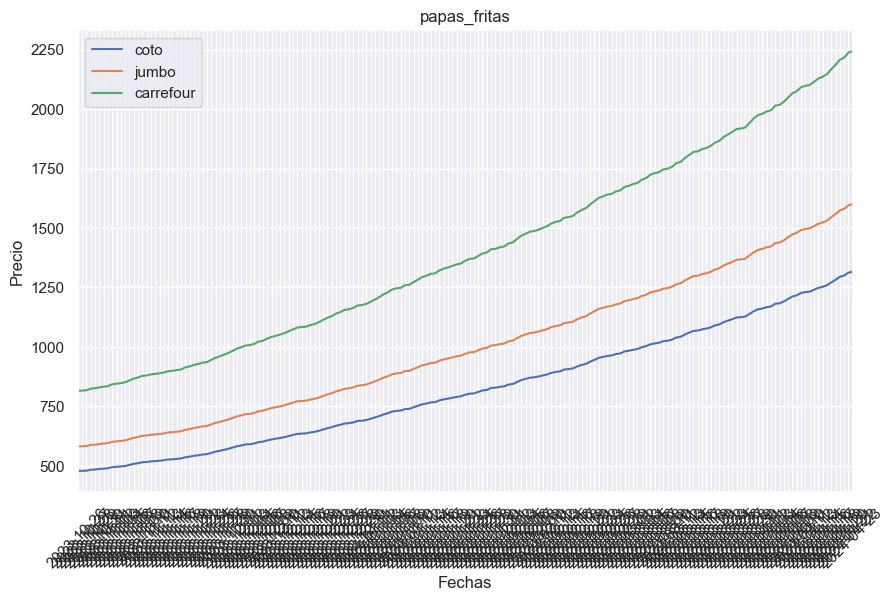

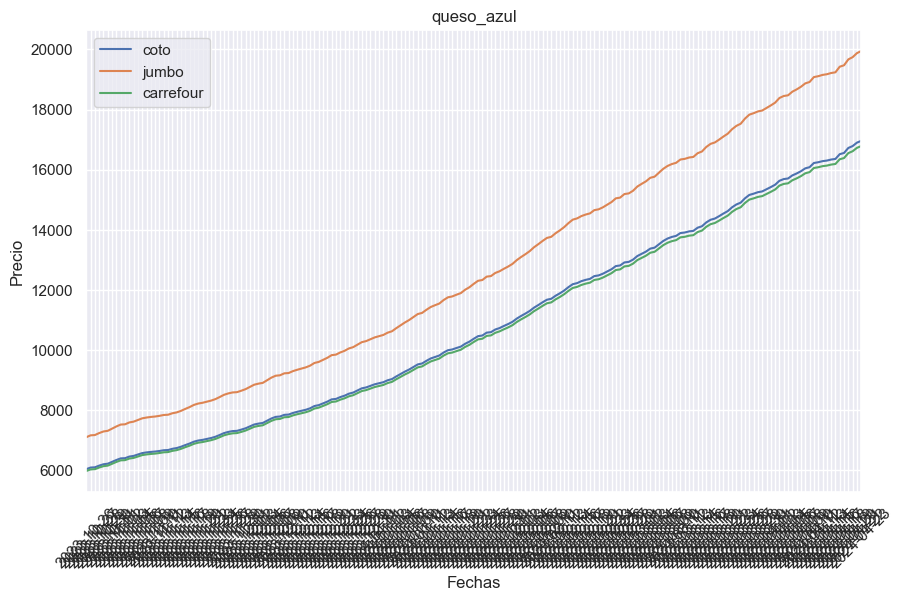

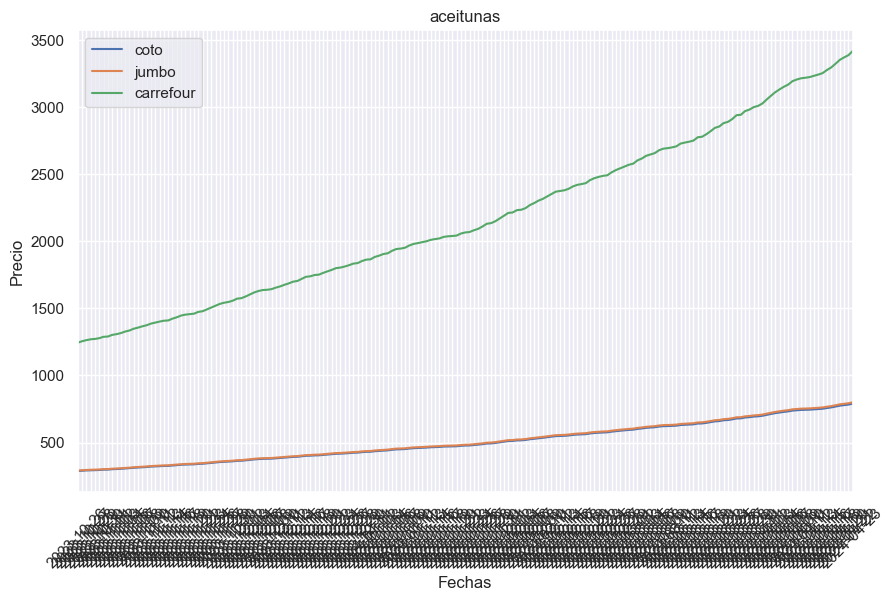

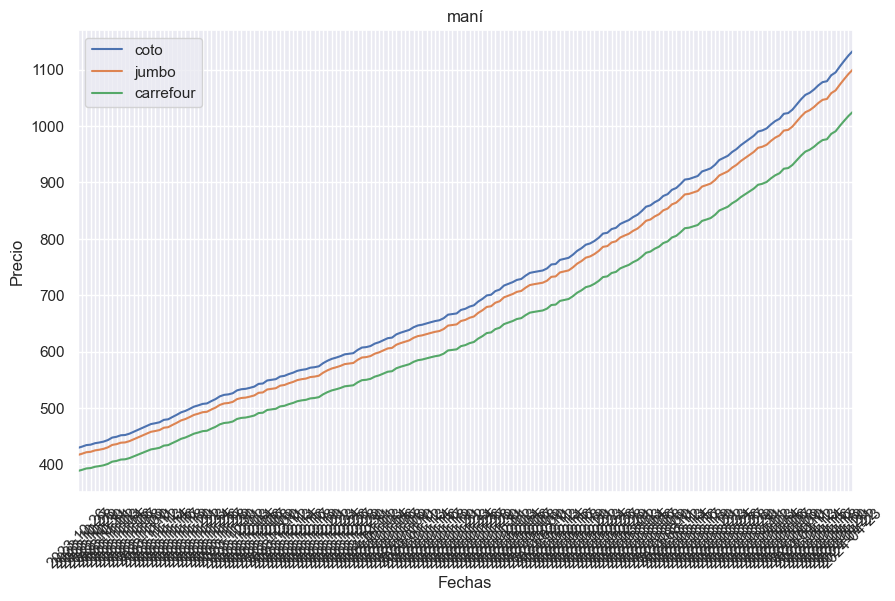

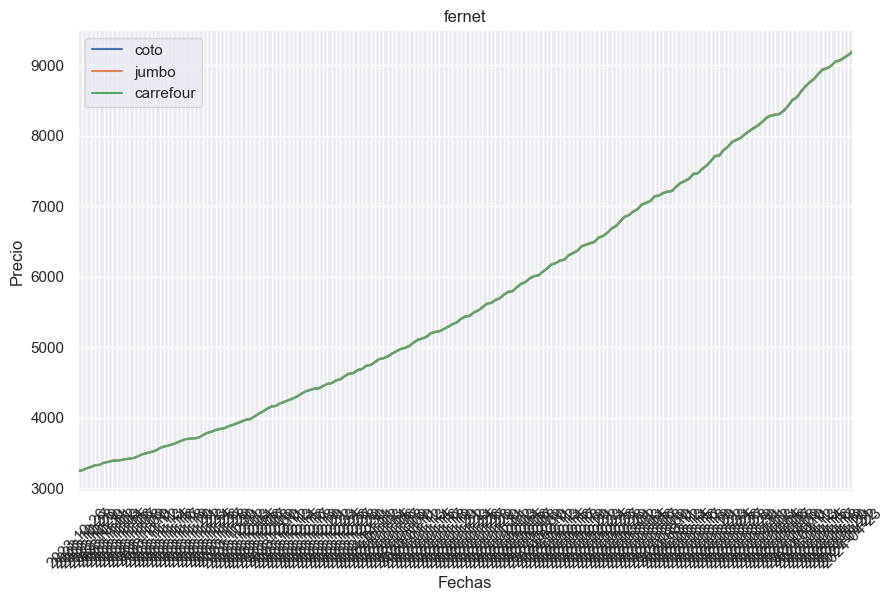

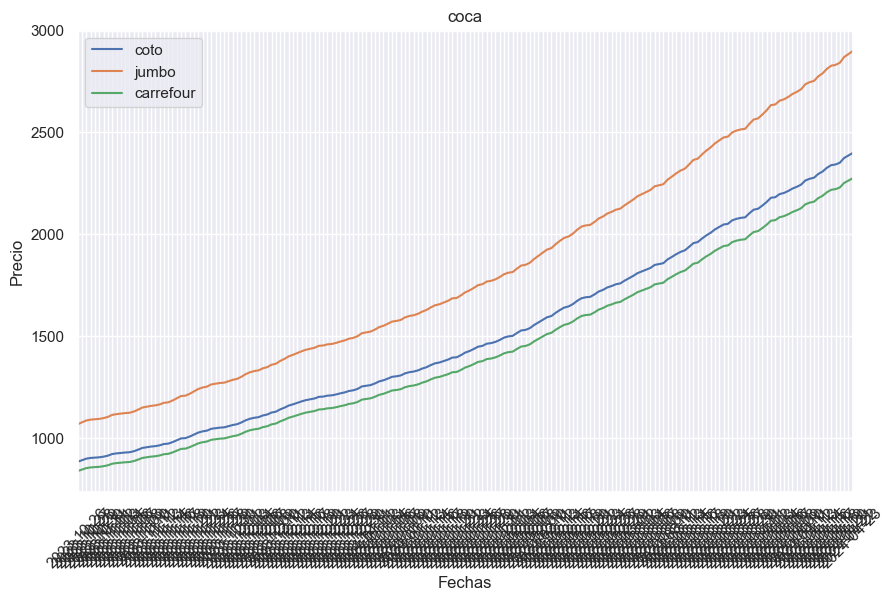

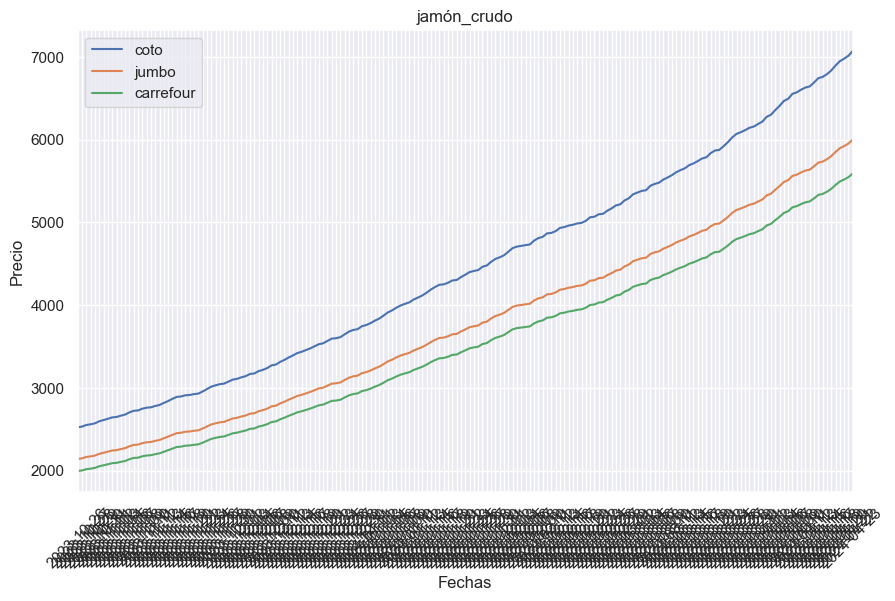

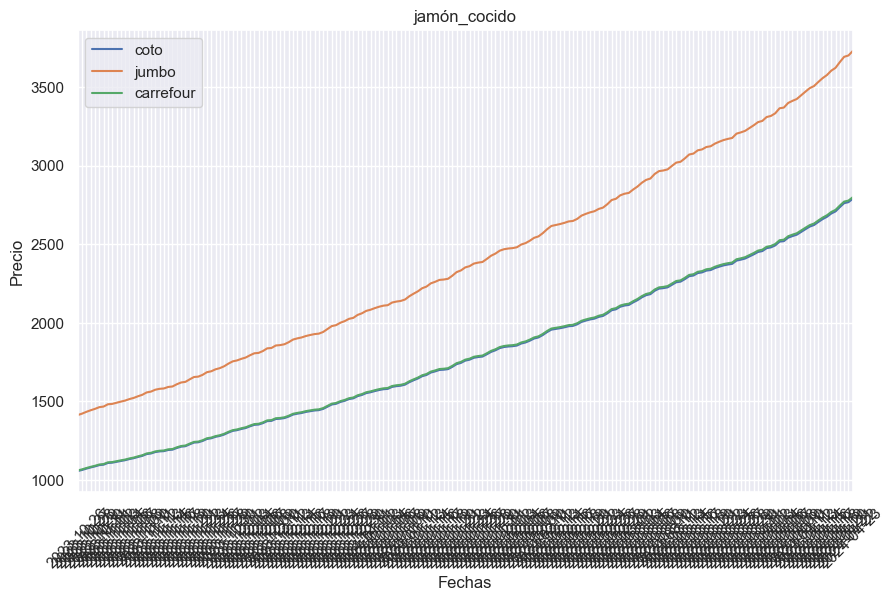

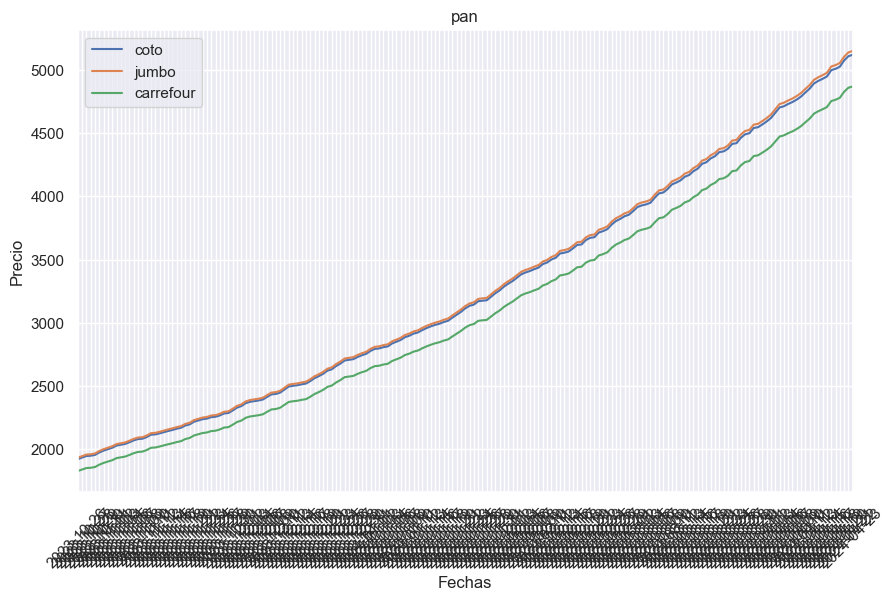

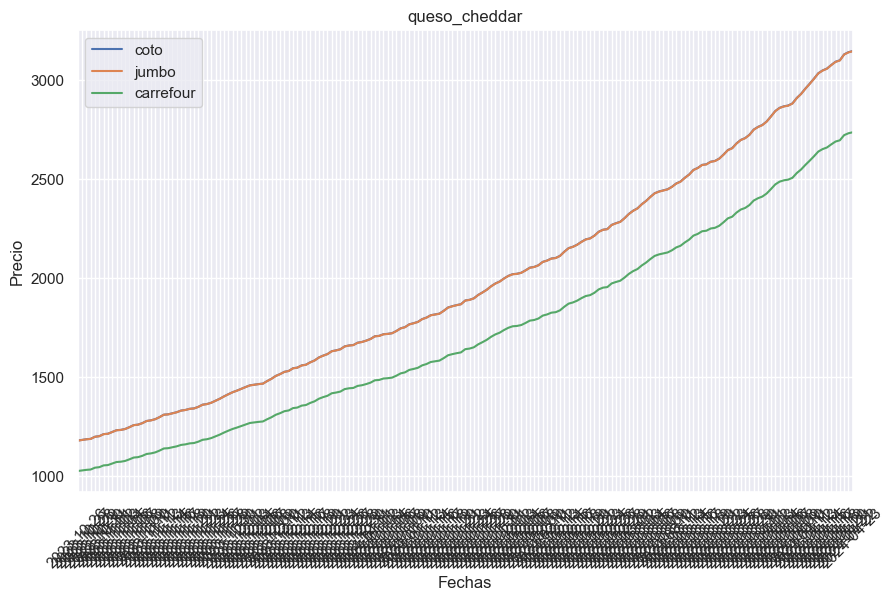

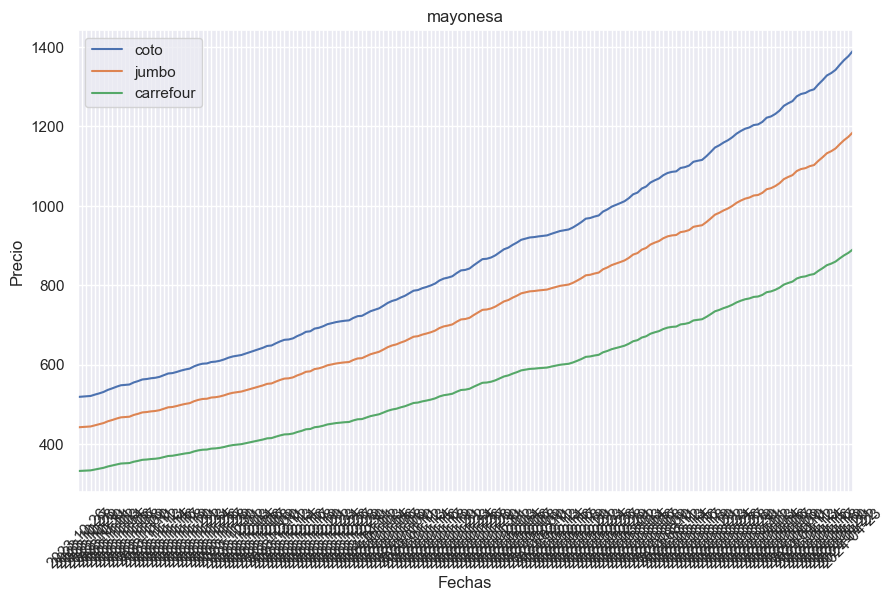

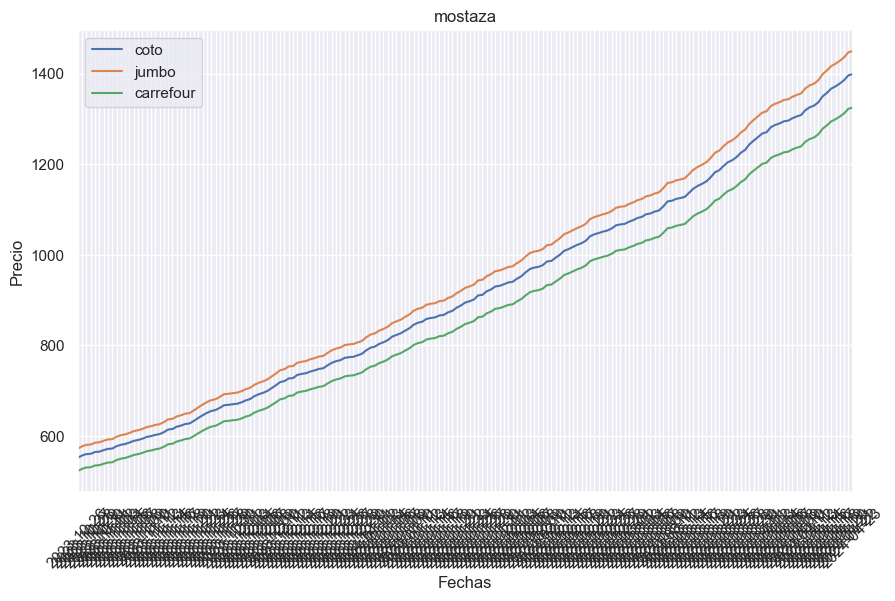

In [33]:
for i in range(len(df_list)):    
    new_df = mock_data_random_decrease(df_list[i][1], 
                                   days_back=180, 
                                   percentage_decrease_min=0.1,
                                   percentage_decrease_max=1)
    
    plot_timeline(new_df , df_list[i][0])
    del new_df